Real Data Cross-Section Example
===============================

Cross-section using real data from soundings.

This example uses actual soundings to create a cross-section. There are
two functions defined to help interpolate radiosonde observations, which
won’t all be at the same level, to a standard grid. The vertical
interpolation assumes a log-linear relationship. Each radisosonde
vertical profile is interpolated first, then the
``scipy.interpolate.griddata`` function is used to generate a full 2D
(x, p) grid between each station. Pyproj is used to calculate the
distance between each station and the standard atmosphere is used to
convert the elevation of each station to a pressure value for plotting
purposes.

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from pyproj import Geod
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from siphon.simplewebservice.wyoming import WyomingUpperAir

Vertical Interpolation Function
-------------------------------

Function interpolates to given pressure level data to set grid.

In [2]:
def vertical_interpolate(vcoord_data, interp_var, interp_levels):
    """A function to interpolate sounding data from each station to
    every millibar. Assumes a log-linear relationship.

    Input
    -----
    vcoord_data : A 1D array of vertical level values (e.g., pressure from a radiosonde)
    interp_var : A 1D array of the variable to be interpolated to all pressure levels
    vcoord_interp_levels : A 1D array containing veritcal levels to interpolate to

    Return
    ------
    interp_data : A 1D array that contains the interpolated variable on the interp_levels
    """

    # Make veritcal coordinate data and grid level log variables
    lnp = np.log(vcoord_data)
    lnp_intervals = np.log(interp_levels)

    # Use numpy to interpolate from observed levels to grid levels
    interp_data = np.interp(lnp_intervals[::-1], lnp[::-1], interp_var[::-1])[::-1]

    # Mask for missing data (generally only near the surface)
    mask_low = interp_levels > vcoord_data[0]
    mask_high = interp_levels < vcoord_data[-1]
    interp_data[mask_low] = interp_var[0]
    interp_data[mask_high] = interp_var[-1]

    return interp_data

Radiosonde Observation Interpolation Function
---------------------------------------------

This function interpolates given radiosonde data into a 2D array for all
meteorological variables given in dataframe. Returns a dictionary that
will have requesite data for plotting a cross section.

In [3]:
def radisonde_cross_section(stns, data, start=1000, end=100, step=10):
    """This function takes a list of radiosonde observation sites with a
    dictionary of Pandas Dataframes with the requesite data for each station.

    Input
    -----
    stns : List of statition three-letter identifiers
    data : A dictionary of Pandas Dataframes containing the radiosonde observations
    for the stations
    start : interpolation start value, optional (default = 1000 hPa)
    end : Interpolation end value, optional (default = 100 hPa)
    step : Interpolation interval, option (default = 10 hPa)

    Return
    ------
    cross_section : A dictionary that contains the following variables

        grid_data : An interpolated grid with 100 points between the first and last station,
        with the corresponding number of vertical points based on start, end, and interval
        (default is 90)
        obs_distance : An array of distances between each radiosonde observation location
        x_grid : A 2D array of horizontal direction grid points
        p_grid : A 2D array of vertical pressure levels
        ground_elevation : A representation of the terrain between radiosonde observation sites
        based on the elevation of each station converted to pressure using the standard
        atmosphere

    """
    # Set up vertical grid, largest value first (high pressure nearest surface)
    vertical_levels = np.arange(start, end-1, -step)

    # Number of vertical levels and stations
    plevs = len(vertical_levels)
    nstns = len(stns)

    # Create dictionary of interpolated values and include neccsary attribute data
    # including lat, lon, and elevation of each station
    lats = []
    lons = []
    elev = []
    keys = data[stns[0]].keys()[:8]
    tmp_grid = dict.fromkeys(keys)

    # Interpolate all variables for each radiosonde observation
    # Temperature, Dewpoint, U-wind, V-wind
    for key in tmp_grid.keys():
        tmp_grid[key] = np.empty((nstns, plevs))
        for station, loc in zip(stns, range(nstns)):
            if key == 'pressure':
                lats.append(data[station].latitude[0])
                lons.append(data[station].longitude[0])
                elev.append(data[station].elevation[0])
                tmp_grid[key][loc, :] = vertical_levels
            else:
                tmp_grid[key][loc, :] = vertical_interpolate(
                    data[station]['pressure'].values, data[station][key].values,
                    vertical_levels)

    # Compute distance between each station using Pyproj
    g = Geod(ellps='sphere')
    _, _, dist = g.inv(nstns*[lons[0]], nstns*[lats[0]], lons[:], lats[:])

    # Compute sudo ground elevation in pressure from standard atmsophere and the elevation
    # of each station
    ground_elevation = mpcalc.height_to_pressure_std(np.array(elev) * units('meters'))

    # Set up grid for 2D interpolation
    grid = dict.fromkeys(keys)
    x = np.linspace(dist[0], dist[-1], 100)
    nx = len(x)

    pp, xx = np.meshgrid(vertical_levels, x)
    pdist, ddist = np.meshgrid(vertical_levels, dist)

    # Interpolate to 2D grid using scipy.interpolate.griddata
    for key in grid.keys():
        grid[key] = np.empty((nx, plevs))
        grid[key][:] = griddata((ddist.flatten(), pdist.flatten()),
                                tmp_grid[key][:].flatten(),
                                (xx, pp),
                                method='cubic')

    # Gather needed data in dictionary for return
    cross_section = {'grid_data': grid, 'obs_distance': dist,
                     'x_grid': xx, 'p_grid': pp, 'elevation': ground_elevation}
    return cross_section

Stations and Time
-----------------

Select cross section stations by creating a list of three-letter
identifiers and choose a date by creating a datetime object

In [4]:
# A roughly east-west cross section
stn_list = ['DNR', 'LBF', 'OAX', 'DVN', 'DTX', 'BUF']

# Set a date and hour of your choosing
date = datetime(2019, 6, 1, 0)

Get Radiosonde Data
-------------------

This example is built around the data from the University of Wyoming
sounding archive and using the Siphon package to remotely access that
data.

In [5]:
# Set up empty dictionary to fill with Wyoming Sounding data
df = {}

# Loop over stations to get data and put into dictionary
for station in stn_list:
    df[station] = WyomingUpperAir.request_data(date, station)

Create Interpolated fields
--------------------------

Use the function ``radisonde_cross_section`` to generate the 2D grid (x,
p) for all radiosonde variables including, Temperature, Dewpoint,
u-component of the wind, and v-component of the wind.

In [6]:
xsect = radisonde_cross_section(stn_list, df)

Calculate Variables for Plotting
--------------------------------

Use MetPy to calculate common variables for plotting a cross section,
specifically potential temperature and mixing ratio

In [7]:
potemp = mpcalc.potential_temperature(
    xsect['p_grid'] * units('hPa'), xsect['grid_data']['temperature'] * units('degC'))

relhum = mpcalc.relative_humidity_from_dewpoint(
    xsect['grid_data']['temperature'] * units('degC'),
    xsect['grid_data']['dewpoint'] * units('degC'))

mixrat = mpcalc.mixing_ratio_from_relative_humidity(relhum,
                                                    xsect['grid_data']['temperature'] *
                                                    units('degC'),
                                                    xsect['p_grid'] * units('hPa'))

Plot Cross Section
------------------

Use standard Matplotlib to plot the now 2D cross section grid using the
data from xsect and those calculated above. Additionally, the actualy
radiosonde wind observations are plotted as barbs on this plot.

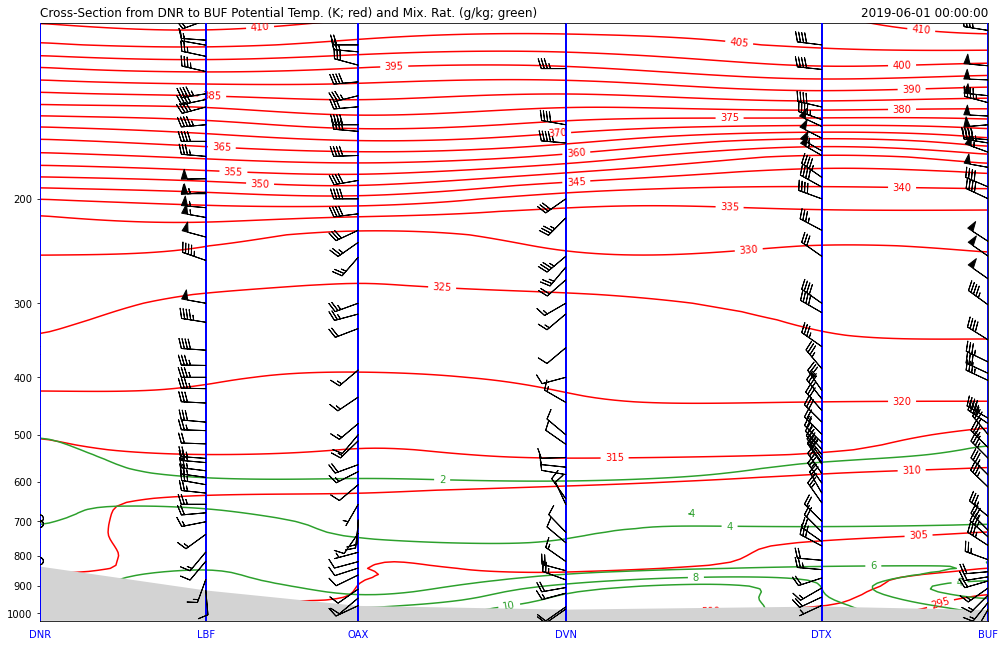

In [8]:
# Start Figure, set big size for cross section
fig = plt.figure(figsize=(17, 11))

# Specify plotting axis (single panel)
ax = plt.subplot(111)

# Set y-scale to be log since pressure decreases exponentially with height
ax.set_yscale('log')

# Set limits, tickmarks, and ticklabels for y-axis
ax.set_ylim([1030, 101])
ax.set_yticks(range(1000, 101, -100))
ax.set_yticklabels(range(1000, 101, -100))

# Invert the y-axis since pressure decreases with increasing height
ax.yaxis_inverted()

# Plot the sudo elevation on the cross section
ax.fill_between(xsect['obs_distance'], xsect['elevation'].m, 1030,
                where=xsect['elevation'].m <= 1030, facecolor='lightgrey',
                interpolate=True, zorder=10)
# Don't plot xticks
plt.xticks([], [])

# Plot wind barbs for each sounding location
for stn, stn_name in zip(range(len(stn_list)), stn_list):
    ax.axvline(xsect['obs_distance'][stn], ymin=0, ymax=1,
               linewidth=2, color='blue', zorder=11)
    ax.text(xsect['obs_distance'][stn], 1100, stn_name, ha='center', color='blue')
    ax.barbs(xsect['obs_distance'][stn], df[stn_name]['pressure'][::2],
             df[stn_name]['u_wind'][::2, None],
             df[stn_name]['v_wind'][::2, None], zorder=15)

# Plot smoothed potential temperature grid (K)
cs = ax.contour(xsect['x_grid'], xsect['p_grid'], gaussian_filter(
    potemp, sigma=1.0), range(0, 500, 5), colors='red')
ax.clabel(cs, fmt='%i')

# Plot smoothed mixing ratio grid (g/kg)
cs = ax.contour(xsect['x_grid'], xsect['p_grid'], gaussian_filter(
    mixrat*1000, sigma=2.0), range(0, 41, 2), colors='tab:green')
ax.clabel(cs, fmt='%i')

# Add some informative titles
plt.title('Cross-Section from DNR to BUF Potential Temp. '
          '(K; red) and Mix. Rat. (g/kg; green)', loc='left')
plt.title(date, loc='right');